In [1]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression

DS_2 = pd.read_csv("ds-boot-1.csv", "\t")
DS_1 = pd.read_csv("ds-boot-2.csv", "\t")

features = DS_1.values[:, 1:29]
targets = DS_1.values[:, 29:].T

## Task 1

In [2]:
def bootstrap(sample, B=1000, s_f=np.mean):
    '''simple bootstrap'''
    gen = np.random.choice(sample, size=(B, len(sample)))
    estimations = s_f(gen, axis=1)
    est_mean = estimations.mean()
    error = (((estimations - est_mean) ** 2).sum() / (B - 1)) ** 0.5
    return est_mean, error

for i in range(1, 6):
    est_mean, error = bootstrap(targets[i - 1], s_f=np.mean)
    print('y' + repr(i), ': mean:', est_mean, ', error:', error)
    est_mean, error = bootstrap(targets[i - 1], s_f=np.median)
    print('y' + repr(i), ': median:', est_mean, ', error:', error)


y1 : mean: 4.027925 , error: 0.465628746433
y1 : median: 4.02725 , error: 0.593440906586
y2 : mean: 5.50609375 , error: 0.525042763308
y2 : median: 6.168 , error: 0.652769759072
y3 : mean: 7.31817175 , error: 0.457851970063
y3 : median: 8.307155 , error: 0.274932298473
y4 : mean: 1.52737575 , error: 0.107265925873
y4 : median: 1.86793 , error: 0.13048195523
y5 : mean: 5.638656 , error: 0.443611843994
y5 : median: 6.17816 , error: 0.424607119118


In [3]:
def lr(A, b):
    '''Linear regression'''
    model = LinearRegression()
    model.fit(A, b)
    return np.concatenate([model.coef_, [model.intercept_]])

def bootstrap_ci(A, b, B=1000):
    original_lr = lr(A, b)
    bootstrap_cfs = []
    n = A.shape[0]
    for _ in range(B):
        idx = np.random.randint(n, size=n)
        bootstrap_cfs.append(lr(A[idx], b[idx]))
    deltas = original_lr - np.array(bootstrap_cfs)    # like on the lectures
    deltas_l, deltas_r = np.percentile(deltas, [2.5, 97.5], axis = 0)
    l_bound = original_lr - deltas_r
    r_bound = original_lr - deltas_l
    return original_lr, l_bound, r_bound   # intercept is the last coeff

for i in range(1, 6):
    original_lr, l_bound, r_bound = bootstrap_ci(features, targets[i - 1])
    print('y' + repr(i))
    print('cfs:',original_lr[:-1])
    print('left bound:', l_bound[:-1])
    print('right bound:', r_bound[:-1])
    print('intercept: ', original_lr[-1], 'l b:', l_bound[-1], 'r b:', r_bound[-1])
    print()


y1
cfs: [ 0.35238786 -0.0872593  -0.47204603  1.12128335 -0.32560952  0.91660928
 -1.07016296 -0.21037968 -0.18459108 -0.34269019  0.76401483  0.04013402
  0.21971176 -0.13237054 -0.80100357  0.25559588  0.57798811 -0.12112813
 -0.41820161 -0.25960643  0.79350498 -0.11337128  0.41039151 -0.3828399
  0.60313631  0.13697149 -0.39762446 -0.10356152]
left bound: [-0.37794467 -0.50974016 -1.02512649 -0.12850722 -0.96085329 -0.52560612
 -1.59038313 -0.79618426 -0.8791886  -0.88096077 -0.2958594  -0.7719742
 -0.60393164 -0.62703331 -1.01818756 -0.25653039 -0.19862442 -0.68164477
 -0.85519103 -0.81868723 -0.1559852  -0.51308235 -0.02534512 -0.80988498
 -0.29240328 -0.4754043  -0.63353116 -0.56793013]
right bound: [ 1.42002543  0.52716889  0.52021739  1.42090417  0.39608348  1.18762811
  0.32751265  0.62593482  0.70442231  0.42541964  1.18549894  0.84824605
  0.88245374  0.5457639   0.15065349  0.63910042  0.85328572  0.44890044
  0.32854176  0.46997246  0.91849945  0.45162597  0.80416911  0.26

## Task2

In [21]:
import matplotlib.pyplot as plt
# from cvxpy import *
from scipy.optimize import minimize
%matplotlib inline
time = DS_2.values.T[0]
bugpd = DS_2.values.T[1]
bugs = DS_2.values.T[2]

[  8.50661571e+03   1.86594978e-03]


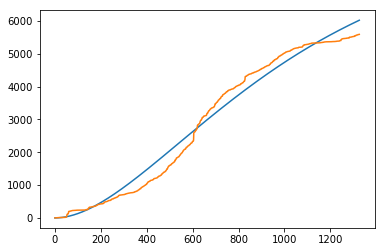

In [22]:
def gos(a, b, t):
    return a * (1 - (1 + b * t) * np.exp(-b * t))



def optimize(time, bugs):
    def loss(x):
        return np.linalg.norm(gos(x[0], x[1], time) - bugs)
    return minimize(loss,  [1., 1.], bounds=((0, None), (0, None))).x

cfs = optimize(time, bugs)
print(cfs)
plt.plot(gos(cfs[0], cfs[1], time))
plt.plot(bugs)

In [55]:
sample_size = 1000
B = 1000
bs_coefs = []
for i in range(B):
#     start_ind = np.random.randint(0, len(time) - sample_size * 2)
    bst = np.random.choice(np.array(range(0, len(time))), sample_size, replace=False)
    bst = np.sort(bst)
    t = time[bst]
    b = np.cumsum(bugpd[bst])
    bs_coefs.append(optimize(t, b))
bs_coefs = np.array(bs_coefs)

In [58]:
deltas = cfs - bs_coefs
deltas_l, deltas_r = np.percentile(deltas, [2.5, 97.5], axis = 0)
l_bound = cfs - deltas_r
r_bound = cfs - deltas_l
print(cfs)
print(l_bound)
print(r_bound)
b_m = np.mean(bs_coefs, axis=0)

[  8.50661571e+03   1.86594978e-03]
[  4.39783483e+03   1.72038054e-03]
[  7.06536774e+03   2.96145815e-03]


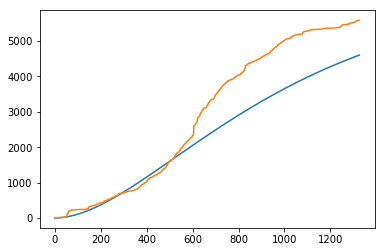

In [59]:
plt.plot(gos(b_m[0], b_m[1], time))
plt.plot(bugs)